https://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [1]:
%%capture

import os, tqdm
import pandas as pd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, transform
import pyproj
import heapq

# Configure OSMnx
ox.config(use_cache=False, log_console=True)

In [2]:
walking_speed = 1.39 # m/s
walking_speed = walking_speed * 60 # m/min

In [3]:
city_boxes = {'Rome': (41.9952, 41.7882, 12.6281, 12.3644), # north, south, east, west
              'Paris': (48.9520, 48.7650, 2.4900, 2.2100),
              'London': (51.6792, 51.2473, 0.2774, -0.4944),
              'Ferrara': (44.9405, 44.7394, 11.77, 11.41),
              'Bologna': (44.5587, 44.4419, 11.4419, 11.2418)}

In [4]:
city = 'Bologna, Italy'
network_type = 'walk'

In [5]:
def process_graph(graph):
    # Project graph
    graph = ox.projection.project_graph(graph, to_crs=3035)

    graph = ox.simplification.consolidate_intersections(
        # Graph to simplify
        graph,
        # buffer around each node (project the graph beforehand)
        tolerance=10,
        # Get result as graph (False to get nodes only as gdf)
        rebuild_graph=True,
        # no dead ends
        dead_ends=False,
        # Reconnect (False to get intersections only)
        reconnect_edges=True
    )

    return ox.convert.to_undirected(graph)

In [6]:
bbox = city_boxes[city.split(', ')[0]]

# graph = ox.graph_from_place(city, network_type=network_type, simplify=True, retain_all=False, truncate_by_edge=True)
# graph = ox.graph_from_point((45.39842, 11.87649), dist=150, network_type=network_type)
graph = ox.graph_from_bbox(bbox = bbox, network_type=network_type)

graph = process_graph(graph)

In [7]:
%%capture
# https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB

education = ox.features.features_from_bbox(bbox = bbox, tags={'amenity':['college','driving_school','kindergarten','language_school','music_school','school','university']}).to_crs(epsg=3035)
entertainment = ox.features.features_from_bbox(bbox = bbox, tags={'amenity':['arts_centre','brothel','casino','cinema','community_center','conference_centre','events_venue','fountain','gambling','lovehotel','nightclub','planetarium','public_bookcase','social_centre','stripclub','studio','swingerclub','theatre']}).to_crs(epsg=3035)
health = ox.features.features_from_bbox(bbox = bbox, tags={'amenity':['clinic','dentist','doctors','hospital','nursing_home','pharmacy','social_facility']}).to_crs(epsg=3035)
posts_banks = ox.features.features_from_bbox(bbox = bbox, tags={'amenity':['atm','bank','bureau_de_change','post_oﬃce']}).to_crs(epsg=3035)
park = ox.features.features_from_bbox(bbox = bbox, tags={'leisure':['park','dog_park']}).to_crs(epsg=3035)
food = ox.features.features_from_bbox(bbox = bbox, tags={'amenity':['restaurant','pub','bar','cafe','fast-food','food_court','ice_cream','biergarten']}).to_crs(epsg=3035)
# shops = ox.features.features_from_bbox(bbox = bbox, tags={'shop': True}).to_crs(epsg=3035)
grocery = ox.features.features_from_bbox(bbox = bbox, tags={'shop':['alcohol','bakery','beverages','brewing_supplies','butcher','cheese','chocolate','coﬀee','confectionery','convenience','deli','dairy','farm','frozenfood','greengrocer','healthfood','ice_cream','pasta','pastry','seafood','spices','tea','water','supermarket','department_store','general','kiosk','mall']}).to_crs(epsg=3035)
shop = ox.features.features_from_bbox(bbox = bbox, tags={'shop':['department_store','general','kiosk','mall','wholesale','baby_goods','bag','boutique','clothes','fabric','fashion_accessories','jewelry','leather','watches','wool','charity','second_hand','variety_store','beauty','chemist','cosmetics','erotic','hairdresser','hairdresser_supply','hearing_aids','herbalist','massage','medical_supply','nutrition_supplements','optician','perfumery','tattoo','agrarian','appliance','bathroom_furnishing','do-it-yourself','electrical','energy','fireplace','florist','garden_centre','garden_furniture','gas','glaziery','groundskeeping','hardware','houseware','locksmith','paint','security','trade','antiques','bed','candles','carpet','curtain','doors','flooring','furniture','household_linen','interior_decoration','kitchen','lighting','tiles','window_blind','computer','electronics','hifi','mobile_phone','radiotechnics','vacuum_cleaner','bicycle','boat','car','car_repair','car_parts','caravan','fuel','fishing','golf','hunting','military_surplus','motorcycle','outdoor','scuba_diving','ski','snowmobile','swimming_pool','trailer','tyres','art','collector','craft','frame','games','model','music','musical_instrument','photo','camera','trophy','video','video_games','anime','books','gift','lottery','newsagent','stationery','ticket','bookmaker','cannabis','copynode','dry_cleaning','e-cigarette','funeral_directors','laundry','money_lender','party','pawnbroker','pet','pet_grooming','pest_control','pyrotechnics','religion','storage_rental','tobacco','toys','travel_agency','vacant','weapons','outpost']}).to_crs(epsg=3035)

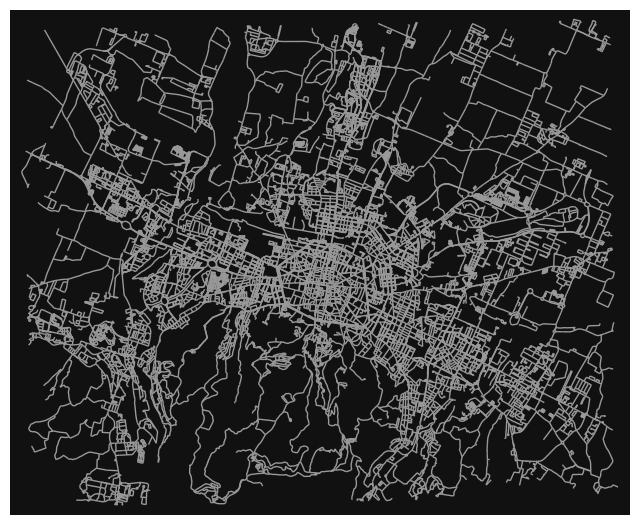

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
ox.plot_graph(graph, node_size=0, edge_linewidth=1)

In [10]:
unique_services = ['education', 'entertainment', 'health', 'posts_banks', 'park', 'food', 'grocery', 'shop']

In [11]:
service_nodes = dict([(unique_services[i],[]) for i in range(len(unique_services))])

_ = [print(k, len(eval(k))) for k, v in service_nodes.items()]

education 328
entertainment 135
health 264
posts_banks 281
park 583
food 1502
grocery 606
shop 1682


In [10]:
# Define a function to insert a service node into the graph
def insert_service_node(graph, service_type, service_lon, service_lat):
    
    # Find the nearest edge and get the geometry to the service location
    u, v, key = ox.nearest_edges(graph, X=service_lon, Y=service_lat) # (u, v have x, y coordinates)

    # Create a point for the service location
    point = Point(service_lon, service_lat) # (lon, lat)

    # If edge is not a straight line, i.e. contains a 'geometry'
    try:
        edge_geom = graph.edges[u, v, key]['geometry']
        edge_weight = edge_geom.length
        edge_weight_linear = (edge_geom.coords[0]).distance(edge_geom.coords[-1]) * 111320

    except:
        # Coordinates of the nearest_edges
        edge_geom = LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),(graph.nodes[v]['x'], graph.nodes[v]['y'])])
        edge_weight = edge_weight_linear = Point(graph.nodes[u]['x'], graph.nodes[u]['y']).distance(Point(graph.nodes[v]['x'], graph.nodes[v]['y'])) * 111320
        # edge_weight = line_string_distance(edge_geom)
        
    # Calculate the closest point on the edge to the service location
    closest_point_on_edge = nearest_points(edge_geom, point)[0] # (lon. lat)

    # Ratio of first segment to total length
    if closest_point_on_edge == Point(edge_geom.coords[0]):
        graph.nodes[u]['service_type'] = service_type
        return
    elif closest_point_on_edge == Point(edge_geom.coords[-1]):
        graph.nodes[v]['service_type'] = service_type
        return

    # Create new edges with the split geometries
    edge_geom_1 = LineString([edge_geom.coords[0], (closest_point_on_edge.x, closest_point_on_edge.y)])
    edge_geom_2 = LineString([(closest_point_on_edge.x, closest_point_on_edge.y), edge_geom.coords[-1]])

    # Insert the new node into the graph
    new_node_id = max(graph.nodes()) + 1  # or any unique ID
    graph.add_node(new_node_id, x=closest_point_on_edge.x, y=closest_point_on_edge.y, service_type=service_type)

    ratio_segment_1 = closest_point_on_edge.distance(Point(edge_geom.coords[0])) / edge_weight_linear

    # Split weight based on ratio
    # weight_segment_1 = line_string_distance(edge_geom_1)
    # weight_segment_2 = line_string_distance(edge_geom_2)
    weight_segment_1 = edge_weight * ratio_segment_1
    weight_segment_2 = edge_weight * (1 - ratio_segment_1)

    # # Remove the old edge and add the new edges
    graph.remove_edge(u, v)
    graph.add_edge(u, new_node_id, key=key, geometry=edge_geom_1, length=weight_segment_1)
    graph.add_edge(new_node_id, v, key=key, geometry=edge_geom_2, length=weight_segment_2)

    return new_node_id

In [11]:
# x = longitude, y = latitude

for s in tqdm.tqdm(unique_services):
    if 'node' in list(eval(s).index.get_level_values(0)):
        for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
            node_id = insert_service_node(graph, s, v[1]['x'], v[1]['y'])
            if node_id is not None:
                service_nodes[s].append(node_id)
    if 'way' in list(eval(s).index.get_level_values(0)):
        for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
            node_id = insert_service_node(graph, s, v[1]['x'], v[1]['y'])
            if node_id is not None:
                service_nodes[s].append(node_id)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
 57%|█████▋    | 4/7 [00:33<00:24,  8.08s/it]/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return li

In [12]:
# s = 'supermarkets'
# if 'node' in list(eval(s).index.get_level_values(0)):
#     for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
#         insert_service_node(graph, s, v[1]['x'], v[1]['y'])
# if 'way' in list(eval(s).index.get_level_values(0)):
#     for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
#         insert_service_node(graph, s, v[1]['x'], v[1]['y'])

In [13]:
# %%capture

# # for s in tqdm.tqdm(unique_services):
# for s in tqdm.tqdm(['supermarkets', 'cafe']):
#     if 'node' in list(eval(s).index.get_level_values(0)):
#         for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
#             node_id = ox.nearest_nodes(graph, v[1]['x'], v[1]['y'])
#             graph.nodes[node_id]['service_type'] = s
#     if 'way' in list(eval(s).index.get_level_values(0)):
#         for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
#             node_id = ox.nearest_nodes(graph, v[1]['x'], v[1]['y'])
#             graph.nodes[node_id]['service_type'] = s

In [14]:
for u, v, k, data in graph.edges(keys=True, data=True):
    if 'geometry' in data:
        data['weight'] = data['geometry'].length / walking_speed
    else:
        data['weight'] = data['length'] / walking_speed

In [15]:
print(f'There are {len(graph)} nodes and {len(graph.edges)} edges in the graph')

There are 10351 nodes and 15769 edges in the graph


# Dijkstra

In [16]:
def custom_dijkstra(G, source, threshold):
    # Initialize distances and visited set
    distances = {node: float('inf') for node in G.nodes}
    distances[source] = 0
    visited = set()

    # Priority queue (heap) to store nodes and their distances
    pq = [(0, source)]

    while pq:
        current_distance, current_node = heapq.heappop(pq)

        # Stop if all nodes within 15 have been visited
        if current_distance > threshold:
            break

        if current_node not in visited:
            visited.add(current_node)

        for neighbor, edge_data in G[current_node].items():
            weight = min([dict(edge_data)[k]['weight'] for k in dict(edge_data).keys()])
            new_distance = current_distance + weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))

    return visited

In [17]:
to_debug = False

def custom_dijkstra_debug(G, source, threshold):
    # Initialize distances and visited set
    distances = {node: float('inf') for node in G.nodes}
    distances[source] = 0
    visited = set()

    # Priority queue (heap) to store nodes and their distances
    pq = [(0, source)]

    print(f'Source: {source}')

    while pq:
        current_distance, current_node = heapq.heappop(pq)

        print(f'Current node: {current_node}, Current distance: {current_distance}')

        # Stop if all nodes within 15 have been visited
        if current_distance > threshold:
            print('Threshold reached, break.')
            break

        if current_node not in visited:
            print(f'Adding {current_node} to visited.')
            visited.add(current_node)

        for neighbor, edge_data in G[current_node].items():
            weight = min([dict(edge_data)[k]['weight'] for k in dict(edge_data).keys()])
            new_distance = current_distance + weight
            print(f'Neighbor: {neighbor}, weight: {weight}, new distance: {new_distance}')
            if new_distance < distances[neighbor]:
                print(f'Updating distance for {neighbor} to {new_distance}')
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))

    return visited

if to_debug:
    FMC = set(graph.nodes())
    for idx, service_type in enumerate(unique_services):
        new_node_id = max(graph.nodes) + idx + 1
        print(f'New node ID: {new_node_id}')
        graph.add_node(new_node_id) # create new node
        graph.add_weighted_edges_from([(new_node_id, node, 0) for node in service_nodes[service_type]])
        FMC_tmp = custom_dijkstra_debug(graph, new_node_id, 15)
        graph.remove_node(new_node_id)
        FMC = FMC.intersection(FMC_tmp)
        print('\n')
    print(f'There are {len(FMC)} nodes in the 15 MC')

# 15 MC

In [18]:
FMC = set(graph.nodes())
for idx, service_type in enumerate(unique_services):
    new_node_id = max(graph.nodes) + idx + 1
    graph.add_node(new_node_id) # create new node
    graph.add_weighted_edges_from([(new_node_id, node, 0) for node in service_nodes[service_type]])
    FMC_tmp = custom_dijkstra(graph, new_node_id, 15)
    graph.remove_node(new_node_id)
    FMC = FMC.intersection(FMC_tmp)
print(f'There are {len(FMC)} nodes in the 15 MC')

There are 2591 nodes in the 15 MC


In [18]:
node_c = ['w'] * len(graph.nodes)

for u in FMC:
    node_c[u] = 'r'

for u in [u for _, v in service_nodes.items() for u in v]:
    node_c[u] = 'b'

In [19]:
edge_c = []

for u, v in graph.edges():
    if u in FMC and v in FMC:
        edge_c.append('r')
    else:
        edge_c.append('k')

In [20]:
ox.plot_graph(graph, bgcolor='w', node_color=node_c, node_edgecolor='k', node_size=8, edge_color=edge_c, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15MC_nodes.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [21]:
ox.plot_graph(graph, bgcolor='w', node_color=node_c, node_edgecolor='k', node_size=8, edge_color=edge_c, edge_linewidth=2, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15MC_nodes_thick.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [22]:
edge_c2 = []

for u, v in graph.edges():
    if u in FMC and v in FMC:
        edge_c2.append('k')
    else:
        edge_c2.append('r')

In [23]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_c2, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15MC.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [24]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_c2, edge_linewidth=2, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15MC_thick.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

# 1-60 MC

In [19]:
max_threshold = 60
MC = [set(graph.nodes())] * max_threshold
for i in range(max_threshold):
    for idx, service_type in enumerate(unique_services):
        new_node_id = max(graph.nodes) + idx + 1
        graph.add_node(new_node_id) # create new node
        graph.add_weighted_edges_from([(new_node_id, node, 0) for node in service_nodes[service_type]])
        FMC_tmp = custom_dijkstra(graph, new_node_id, i+1)
        graph.remove_node(new_node_id)
        MC[i] = MC[i].intersection(FMC_tmp)
    print(f'There are {len(MC[i])} nodes in the {i+1} MC')

There are 0 nodes in the 1 MC
There are 5 nodes in the 2 MC
There are 51 nodes in the 3 MC
There are 197 nodes in the 4 MC
There are 429 nodes in the 5 MC
There are 678 nodes in the 6 MC
There are 876 nodes in the 7 MC
There are 1067 nodes in the 8 MC
There are 1253 nodes in the 9 MC
There are 1469 nodes in the 10 MC
There are 1716 nodes in the 11 MC
There are 1950 nodes in the 12 MC
There are 2155 nodes in the 13 MC
There are 2374 nodes in the 14 MC
There are 2591 nodes in the 15 MC
There are 2820 nodes in the 16 MC
There are 3084 nodes in the 17 MC
There are 3353 nodes in the 18 MC
There are 3592 nodes in the 19 MC
There are 3808 nodes in the 20 MC
There are 4013 nodes in the 21 MC
There are 4181 nodes in the 22 MC
There are 4319 nodes in the 23 MC
There are 4477 nodes in the 24 MC
There are 4611 nodes in the 25 MC
There are 4727 nodes in the 26 MC
There are 4840 nodes in the 27 MC
There are 4940 nodes in the 28 MC
There are 5042 nodes in the 29 MC
There are 5134 nodes in the 30 MC
T

In [20]:
MC_unique = {key + 1: MC[key].difference(*MC[:key]) for key in range(max_threshold)}

In [21]:
colours = ox.plot.get_colors(n=max_threshold+1, cmap="copper") # cool, winter, Blues

In [22]:
node_cs = [colours[max_threshold]] * len(graph.nodes)

for t in range(max_threshold - 1, -1, -1):
    for u in MC[t]:
        node_cs[u] = colours[t]

for u in [u for _, v in service_nodes.items() for u in v]:
    node_cs[u] = 'r'

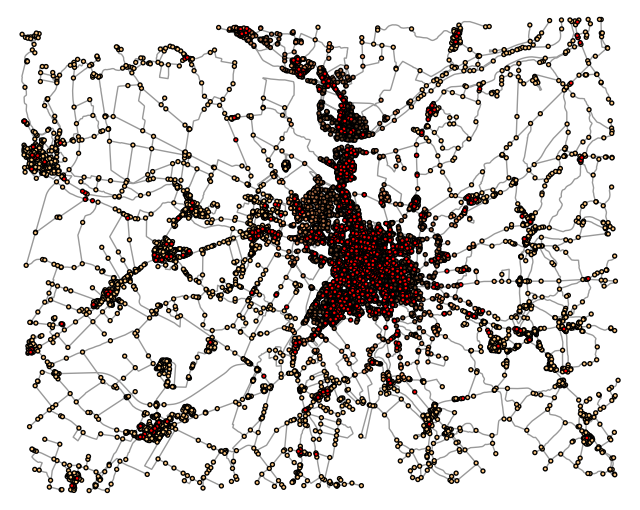

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
ox.plot_graph(graph, bgcolor='w', node_color=node_cs, node_edgecolor='k', node_size=8, edge_linewidth=1, edge_alpha=1)

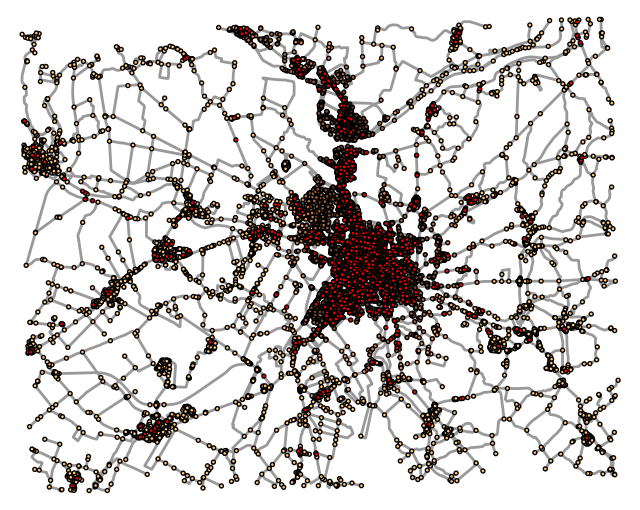

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [24]:
ox.plot_graph(graph, bgcolor='w', node_color=node_cs, node_edgecolor='k', node_size=8, edge_linewidth=2, edge_alpha=1)

In [29]:
ox.plot_graph(graph, bgcolor='w', node_color=node_cs, node_edgecolor='k', node_size=8, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_30tMC_nodes.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [30]:
ox.plot_graph(graph, bgcolor='w', node_color=node_cs, node_edgecolor='k', node_size=8, edge_linewidth=2, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_30tMC_nodes_thick.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [25]:
def find_key_of_value(d, number):
    for key, values in d.items():
        if number in values:
            return key
    return max(d.keys()) + 1

In [26]:
edge_cs = [colours[max_threshold]] * len(graph.edges()) # blues[max_threshold-1] darkest

for i, (u, v) in enumerate(graph.edges()):
    idx = max(find_key_of_value(MC_unique, u), find_key_of_value(MC_unique, v))
    if idx <= max_threshold:
        edge_cs[i] = colours[idx-1]

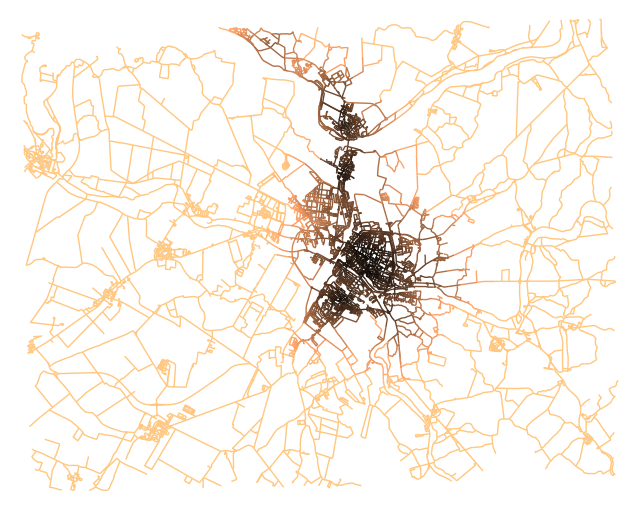

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=1, edge_alpha=1)

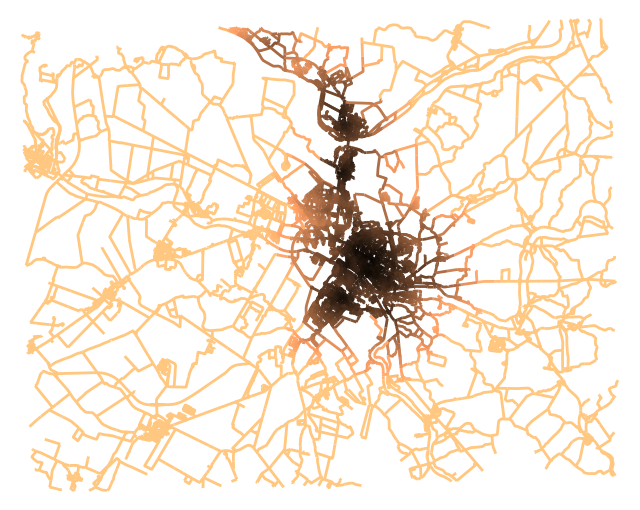

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
ox.plot_graph(graph, bgcoloTr='w', node_size=0, edge_color=edge_cs, edge_linewidth=2, edge_alpha=1)

In [33]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_30tMC.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [34]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=2, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_30tMC_thick.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

# 15 tMC

In [35]:
half_max_threshold = int(max_threshold/2)

half_colours = ox.plot.get_colors(n=half_max_threshold+1, cmap="copper") # cool, winter

edge_cs = [half_colours[half_max_threshold]] * len(graph.edges())

for i, (u, v) in enumerate(graph.edges()):
    idx = max(find_key_of_value(MC_unique, u), find_key_of_value(MC_unique, v))
    if idx <= half_max_threshold:
        edge_cs[i] = half_colours[idx-1]

ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15tMC.png'), show=False, close=True)

ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=2, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15tMC_thick.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

# Save data

In [36]:
to_csv = True

os.makedirs('./data', exist_ok=True)
os.makedirs('./data/master/', exist_ok=True)

if to_csv:
    nodes, edges = ox.graph_to_gdfs(graph)

    nodes.to_csv(os.path.join('./data/master', city.split(', ')[0] + '_nodes.csv'), index=True)
    edges.to_csv(os.path.join('./data/master', city.split(', ')[0] + '_edges.csv'), index=True)

    pd.DataFrame(FMC).to_csv(os.path.join('./data/master', city.split(', ')[0] + '_FMC.csv'), index=False)
    pd.DataFrame(MC).to_csv(os.path.join('./data/master', city.split(', ')[0] + '_MC.csv'), index=False)

    edges = edges.reset_index().groupby(['u', 'v'], as_index=False).agg({'weight': 'min'}).rename(columns={'u': 'source', 'v': 'target'}, inplace=False)
    nodes = nodes.reset_index().rename(columns={'osmid': 'id', 'service_type': 'label'}, inplace=False)[['id','label']]

    nodes.to_csv(os.path.join('./data', city.split(', ')[0] + '_nodes.csv'), index=False)
    edges.to_csv(os.path.join('./data', city.split(', ')[0] + '_edges.csv'), index=False)

# Reload graph

In [ ]:
edges_df = pd.read_csv('./min_city/data/edges.csv')
nodes_df = pd.read_csv('./min_city/data/nodes.csv')

In [ ]:
graph_df = nx.from_pandas_edgelist(edges_df, 'source', 'target', ['weight'], create_using=nx.MultiDiGraph())

# Assuming your nodes_df has columns 'node', 'name', and 'gender'
nx.set_node_attributes(graph_df, pd.Series(nodes_df['label'], index=nodes_df['id']).to_dict(), 'label')

for node_id in graph_df.nodes():
    graph_df.nodes[node_id]['label'] = nodes_df.loc[node_id, 'label']

# DELETE

In [107]:
FMC_Rust = set(pd.read_csv('./min_city/output.csv', header=None))

In [108]:
node_c = ['w'] * len(graph.nodes)

for u in FMC_Rust:
    node_c[u] = 'r'

for u in [u for _, v in service_nodes.items() for u in v]:
    node_c[u] = 'b'

edge_c = []

for u, v in graph.edges():
    if u in FMC_Rust and v in FMC_Rust:
        edge_c.append('r')
    else:
        edge_c.append('k')

In [110]:
ox.plot_graph(graph, bgcolor='w', node_color=node_c, node_edgecolor='k', node_size=8, edge_color=edge_c, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15_MC_nodes_Rust.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [111]:
edge_c2 = []

for u, v in graph.edges():
    if u in FMC_Rust and v in FMC_Rust:
        edge_c2.append('k')
    else:
        edge_c2.append('r')

In [112]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_c2, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_15_MC_Rust.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)